# Import Library

In [102]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk import pos_tag
from nltk.tag import pos_tag

import newspaper
from newspaper import Article

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

import re
import time
import string
import json
import operator
from collections import Counter

import matplotlib.pyplot as plt


# Read Data

In [3]:
header = ["GlobalEventId", "sqldate", "MonthYear","Year",
               "Actor1Code","Actor1Name","Actor1CountryCode","Actor1KnownGroupCode","Actor1Type1Code",
               "Actor2Code","Actor2Name","Actor2CountryCode","Actor2KnownGroupCode","Actor2Type1Code",
               "IsRootEvent","EventCode","EventBaseCode","EventRootCode",
               "QuadClass","GoldsteinScale","NumMentions","NumSources","NumArticles","AvgTone",
               "Actor1Geo_FullName","Actor1Geo_CountryCode","Actor1Geo_ADM1Code","Actor1Geo_Lat","Actor1Geo_Long",
               "Actor2Geo_FullName","Actor2Geo_CountryCode","Actor2Geo_ADM1Code","Actor2Geo_Lat","Actor2Geo_Long",
               "ActionGeo_FullName","ActionGeo_CountryCode","ActionGeo_ADM1Code","ActionGeo_Lat","ActionGeo_Long",
               "SOURCEURL"]

In [4]:
#ubah path_clean sesuai tempat clean di lokal
#path_clean = 'E:/digitalent/2016-clean.csv'
path_clean = 'E:/digitalent-project/csv/2017-clean.csv'
data_gdelt = pd.read_csv(path_clean, delimiter = ',', encoding = "ISO-8859-1", names=header)
data_gdelt.sample(4)

,GlobalEventId,sqldate,MonthYear,Year,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1Type1Code,Actor2Code,...,Actor2Geo_CountryCode,Actor2Geo_ADM1Code,Actor2Geo_Lat,Actor2Geo_Long,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,SOURCEURL
1140958,701738935,20171027,201710,2017,NaN,NaN,NaN,NaN,NaN,COP,...,AS,AS01,-35.2167,149.1330,"Gungahlin, Australian Capital Territory, Austr...",AS,AS01,-35.21670,149.1330,http://www.abc.net.au/news/2017-10-28/canberra...
1084324,697791027,20171014,201710,2017,CAN,CANADA,CAN,NaN,NaN,BUS,...,CA,CA,60.0000,-96.0000,Canada,CA,CA,60.00000,-96.0000,http://iphonefresh.com/2017/10/14/general-moto...
655509,664931803,20170614,201706,2017,MED,SPOKESMAN,NaN,NaN,MED,GOV,...,US,USNY,42.1497,-74.9384,"Washington, District of Columbia, United States",US,USDC,38.89510,-77.0364,https://www.businessinsider.com.au/trump-is-re...
894244,683901924,20170824,201708,2017,REL,PRIEST,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"Bangui, Bangui, Central African Republic",CT,CT18,4.36667,18.5833,https://www.catholicregister.org/home/internat...


### Inisialisasi Stopwords

In [5]:
stop_words = set(stopwords.words('english'))

### Inisialisasi Stemming

In [6]:
ps = nltk.stem.PorterStemmer()

### Inisialisasi dict res untuk menampung result

In [7]:
res = {}

# Fungsi Scrapping

In [8]:
# sebelum file json ada
def scrap_article(gid, source):
    start = time.time()
    article = Article(source)
    article.download()
    article.parse()
    article.nlp()
    
    #LOWERCASE
    txt = article.text.lower()
    
    #change nonword to space   
    txt_clean = re.sub(r'[^a-zA-Z]', ' ', txt)
    
    #TOKENISASI , STEM, HAPUS PROPERNOUN, DAN HAPUS STOPWORD
    tagged_sentence = nltk.pos_tag(txt_clean.split())
    
    filtered_sentence=[]
    for initword, tag in tagged_sentence:
        word = ps.stem(initword)
        if len(word)>1 and (word not in stop_words) and tag != 'NNP' and tag != 'NNPS':
            filtered_sentence.append(word)

    #print("TOKENS",type(filtered_sentence))
    
    #COUNT VECTOR: hitung kemunculan tiap kata
    gid_str = str(gid)
    val = dict((Counter(filtered_sentence)))
    
    #masukkan hasil ke dict res dengan id : gid_str dan value: val
    res[gid_str] = val
    end = time.time()
    waktu = end-start
    #print(waktu)
    return val
    

## WARNING!!

In [8]:
#jalankan jika sudah ada file json
def scrap_article(gid, source):
    start = time.time()
    article = Article(source)
    article.download()
    article.parse()
    article.nlp()
    
    #LOWERCASE
    txt = article.text.lower()
    
    #change nonword to space   
    txt_clean = re.sub(r'[^a-zA-Z]', ' ', txt)
    
    #TOKENISASI , STEM, HAPUS PROPERNOUN, DAN HAPUS STOPWORD
    tagged_sentence = nltk.pos_tag(txt_clean.split())
    
    filtered_sentence=[]
    for initword, tag in tagged_sentence:
        word = ps.stem(initword)
        if len(word)>1 and (word not in stop_words) and tag != 'NNP' and tag != 'NNPS':
            filtered_sentence.append(word)

    #print("TOKENS",type(filtered_sentence))
    
    #COUNT VECTOR: hitung kemunculan tiap kata
    gid_str = str(gid)
    val = dict((Counter(filtered_sentence)))
    
    #masukkan hasil ke dict res dengan id : gid_str dan value: val
    res[gid_str] = val
    
    #update JSON file
    a_dict = {gid_str: val}

    with open('data.json') as f:
        data = json.load(f)

    data.update(a_dict)

    with open('data.json', 'w') as f:
        json.dump(data, f)
    
    end = time.time()
    waktu = end-start
    #print(waktu)
    return val

##### Contoh 1 url

In [18]:
sample=data_gdelt['SOURCEURL'][0]
sample
sample_ID = data_gdelt['GlobalEventId'][0]
scrap_article(sample_ID, sample)

{'close': 1,
 'rochest': 6,
 'man': 2,
 'accus': 2,
 'isi': 10,
 'sympath': 2,
 'plan': 7,
 'kill': 7,
 'patron': 3,
 'restaur': 3,
 'bar': 3,
 'new': 10,
 'year': 13,
 'eve': 8,
 'feder': 6,
 'author': 6,
 'alleg': 3,
 'angi': 1,
 'nassar': 1,
 'gari': 1,
 'craig': 1,
 'emanuel': 4,
 'lutchman': 26,
 'photo': 1,
 'provid': 3,
 'attack': 5,
 'say': 5,
 'could': 3,
 'gruesom': 1,
 'assault': 2,
 'islam': 4,
 'state': 9,
 'arm': 1,
 'knive': 2,
 'machet': 2,
 'take': 1,
 'life': 1,
 'old': 1,
 'allegedli': 6,
 'said': 11,
 'tuesday': 1,
 'hi': 9,
 'appar': 1,
 'plot': 4,
 'merchant': 3,
 'grill': 2,
 'road': 1,
 'problem': 1,
 'fbi': 12,
 'joint': 2,
 'terror': 3,
 'task': 2,
 'forc': 2,
 'wednesday': 2,
 'arrest': 8,
 'charg': 3,
 'offer': 1,
 'materi': 3,
 'support': 2,
 'terrorist': 5,
 'appear': 3,
 'court': 6,
 'thursday': 10,
 'morn': 1,
 'media': 2,
 'wa': 10,
 'alert': 1,
 'advanc': 1,
 'schedul': 3,
 'return': 2,
 'jan': 1,
 'detain': 1,
 'populac': 1,
 'alreadi': 1,
 'fear': 1,

In [13]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\suci.lestari\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Proses Menghasilkan Dict

In [10]:
start2=start =time.time()
progress = 0
lenart = 1000
for x in range(1000):
    global start
    global progress
    progress += 1
    try:
        sample_=data_gdelt['SOURCEURL'][x]
        sample_ID_ = data_gdelt['GlobalEventId'][x]
        aaa = scrap_article(sample_ID_, sample_)
        #print(aaa, type(aaa))
    except:
        print('gagal', sample_)
        pass
    end = time.time()
    if progress%10==0:
        print('\r {} percent, {} position, {} per second '.format(str(float(progress / lenart)), str(progress), (1 / (end - start)))) #lets us see how much time is 
end2 = time.time()

print('waktu',end2-start2)

gagal http://www.princegeorgecitizen.com/news/local-news/senior-vancouver-police-officer-charged-with-sex-crimes-and-breach-of-trust-1.5803598
gagal http://www.princegeorgecitizen.com/news/local-news/a-list-of-canadians-who-ran-into-trouble-abroad-in-2016-1.4405000
gagal http://www.princegeorgecitizen.com/news/local-news/a-list-of-canadians-who-ran-into-trouble-abroad-in-2016-1.4405000
gagal http://www.princegeorgecitizen.com/news/local-news/a-list-of-canadians-who-ran-into-trouble-abroad-in-2016-1.4405000
gagal http://www.princegeorgecitizen.com/news/local-news/a-list-of-canadians-who-ran-into-trouble-abroad-in-2016-1.4405000
gagal http://www.princegeorgecitizen.com/news/local-news/a-list-of-canadians-who-ran-into-trouble-abroad-in-2016-1.4405000
 0.01 percent, 10 position, 0.03736184823309795 per second 
gagal http://www.princegeorgecitizen.com/news/local-news/a-list-of-canadians-who-ran-into-trouble-abroad-in-2016-1.4405000
gagal http://kdhnews.com/news/ap/congo-president-to-leave-a

gagal http://www.sabc.co.za/news/a/2f8450004f87d8b3af2fafbf0411aa0a/Burundian-President-issues-ultimatum-to-AU-and-EU-over-unpaid-salaries
gagal http://www.wcax.com/story/34159314/geraldine-ferraros-son-pardoned-for-1988-cocaine-conviction
gagal http://www.nigeriatoday.ng/2016/12/cbn-has-not-printed-any-money-buhari-using-over-36b-left-by-jonathan-reno/
gagal http://www.nigeriatoday.ng/2016/12/cbn-has-not-printed-any-money-buhari-using-over-36b-left-by-jonathan-reno/
 0.16 percent, 160 position, 0.0018633690213068071 per second 
gagal http://www.nigeriatoday.ng/2016/12/cbn-has-not-printed-any-money-buhari-using-over-36b-left-by-jonathan-reno/
gagal https://www.niyitabiti.net/2016/12/cbn-has-not-printed-any-money-buhari-using-over-36b-left-by-jonathan-reno/
gagal https://www.niyitabiti.net/2016/12/cbn-has-not-printed-any-money-buhari-using-over-36b-left-by-jonathan-reno/
gagal http://www.nigeriatoday.ng/2016/12/cbn-has-not-printed-any-money-buhari-using-over-36b-left-by-jonathan-reno/
g

gagal http://www.tbo.com/shumlin-issues--pardons-mostly-for-drug-related-crimes-ap_election414841991fcf4d5b8601c08a2c0f0fe4
gagal http://www.tbo.com/shumlin-issues--pardons-mostly-for-drug-related-crimes-ap_election414841991fcf4d5b8601c08a2c0f0fe4
 0.54 percent, 540 position, 0.00043817664915688377 per second 
gagal http://www.tbo.com/shumlin-issues--pardons-mostly-for-drug-related-crimes-ap_election414841991fcf4d5b8601c08a2c0f0fe4
 0.55 percent, 550 position, 0.0004339613660385023 per second 
gagal http://www.tbo.com/shumlin-issues--pardons-mostly-for-drug-related-crimes-ap_election414841991fcf4d5b8601c08a2c0f0fe4
gagal http://idrw.org/china-offers-new-proof-that-it-is-a-major-challenge-for-modi/
gagal http://idrw.org/china-offers-new-proof-that-it-is-a-major-challenge-for-modi/
 0.56 percent, 560 position, 0.0004295518109366205 per second 
gagal http://www.news18.com/news/world/wife-of-murdered-greek-ambassador-jailed-in-brazil-1329932.html
gagal http://www.kaieteurnewsonline.com/201

gagal http://www.ntnews.com.au/business/breaking-news/bolivias-drought-highlights-shortcomings/news-story/0c0fb60d39da0e53b83796e556a6076d?nk=7f5634c72747dcc5e431a9b5f2e11a56-1483254114
 0.8 percent, 800 position, 0.0003053675294606423 per second 
gagal http://www.ntnews.com.au/business/breaking-news/bolivias-drought-highlights-shortcomings/news-story/0c0fb60d39da0e53b83796e556a6076d?nk=7f5634c72747dcc5e431a9b5f2e11a56-1483254114
gagal http://www.ntnews.com.au/business/breaking-news/bolivias-drought-highlights-shortcomings/news-story/0c0fb60d39da0e53b83796e556a6076d?nk=7f5634c72747dcc5e431a9b5f2e11a56-1483254114
gagal http://www.ntnews.com.au/business/breaking-news/bolivias-drought-highlights-shortcomings/news-story/0c0fb60d39da0e53b83796e556a6076d?nk=7f5634c72747dcc5e431a9b5f2e11a56-1483254114
gagal http://www.stuff.co.nz/national/88042520/Akaroa-dubbed-Tack-aroa-after-cruise-ship-boom
gagal http://www.thefrontierpost.com/article/424096/ashraf-backs-extension-to-mily-courts/
 0.81 per

gagal http://www.whistlerquestion.com/the-latest-cosby-citing-news-coverage-seeks-to-move-trial-1.5869421
gagal http://www.sfgate.com/news/world/article/Impeached-S-Korean-leader-rejects-accusations-10829279.php
 0.99 percent, 990 position, 0.00021167805060906582 per second 
gagal http://www.bendbulletin.com/home/4938113-151/the-state-of-bend-real-estate-as-2017
gagal Yonhap news agency in English/BBC Monitoring/(c) BBC
gagal http://isp.netscape.com/news/story.jsp?idq=/ff/story/0002/20170101/KBN14L0UV_2.htm
gagal http://wshh.com/artist/ron-antill/
 1.0 percent, 1000 position, 0.00020994104019007523 per second 
waktu 4763.242094516754


In [ ]:
print(type(aaa))

In [22]:
len(data_gdelt)

1392383

# Write hasil ke json

In [13]:
#Tidak dijalankan jika data.json sudah ada
with open('data.json', 'w') as fp:
    json.dump(res, fp)

# Transform Count Vect to Tfidf

### read json file

In [14]:
with open('data.json', 'r') as fp:
    data_counter = json.load(fp)

### add event ID and bag of words to different array

In [15]:
eventID = []
DictVector = []

In [16]:
for k,v in data_counter.items():
    eventID.append(k)
    DictVector.append(v)

### vectorize bag of words from all news

In [17]:
vec = DictVectorizer()
DictArray = vec.fit_transform(DictVector).toarray()

### transform to TFIDF

In [18]:
tfidf_transformer = TfidfTransformer(use_idf=False)
tfidf_transform=tfidf_transformer.transform(DictArray, copy = True)
print(tfidf_transform)
print(DictArray)
print(tfidf_transform.todense())

  (0, 79)	0.061898446059017294
  (0, 212)	0.061898446059017294
  (0, 610)	0.061898446059017294
  (0, 641)	0.061898446059017294
  (0, 754)	0.061898446059017294
  (0, 1060)	0.061898446059017294
  (0, 1073)	0.061898446059017294
  (0, 1684)	0.061898446059017294
  (0, 1902)	0.061898446059017294
  (0, 2274)	0.061898446059017294
  (0, 2398)	0.061898446059017294
  (0, 2463)	0.1856953381770519
  (0, 2511)	0.061898446059017294
  (0, 2529)	0.061898446059017294
  (0, 2762)	0.12379689211803459
  (0, 2872)	0.1856953381770519
  (0, 3137)	0.061898446059017294
  (0, 3291)	0.061898446059017294
  (0, 3538)	0.061898446059017294
  (0, 3711)	0.061898446059017294
  (0, 4240)	0.061898446059017294
  (0, 4283)	0.061898446059017294
  (0, 4789)	0.061898446059017294
  (0, 4953)	0.061898446059017294
  (0, 4990)	0.061898446059017294
  :	:
  (748, 11147)	0.019230769230769232
  (748, 11245)	0.019230769230769232
  (748, 11248)	0.019230769230769232
  (748, 11289)	0.019230769230769232
  (748, 11316)	0.019230769230769232


### header bag of words

In [36]:
vocabulary = vec.vocabulary_

In [37]:
# sort vocabulary by value (for header)
header = sorted(vocabulary.items(), key=operator.itemgetter(1))
header

[('aa', 0),
 ('aadhaar', 1),
 ('aadmi', 2),
 ('aaf', 3),
 ('aam', 4),
 ('aap', 5),
 ('aaron', 6),
 ('aaronovitch', 7),
 ('ab', 8),
 ('ababa', 9),
 ('abadi', 10),
 ('abandon', 11),
 ('abat', 12),
 ('abba', 13),
 ('abc', 14),
 ('abd', 15),
 ('abdul', 16),
 ('abdulai', 17),
 ('abdulaziz', 18),
 ('abdulkarim', 19),
 ('abdullah', 20),
 ('abdullahi', 21),
 ('abdulmumin', 22),
 ('abdulrahman', 23),
 ('abdulrashe', 24),
 ('abdur', 25),
 ('abdusallam', 26),
 ('abeokuta', 27),
 ('abet', 28),
 ('abid', 29),
 ('abidin', 30),
 ('abil', 31),
 ('abington', 32),
 ('abject', 33),
 ('abl', 34),
 ('aboard', 35),
 ('abolish', 36),
 ('abolit', 37),
 ('abort', 38),
 ('abound', 39),
 ('abov', 40),
 ('abp', 41),
 ('abraham', 42),
 ('abras', 43),
 ('abroad', 44),
 ('abrupt', 45),
 ('abruptli', 46),
 ('abscond', 47),
 ('absenc', 48),
 ('absent', 49),
 ('absolut', 50),
 ('absolv', 51),
 ('absorb', 52),
 ('abstain', 53),
 ('abstent', 54),
 ('absurd', 55),
 ('absurdli', 56),
 ('abu', 57),
 ('abubakar', 58),
 ('abu

In [39]:
header_tfidf=[]
for k,v in header:
    header_tfidf.append(k)
#header_tfidf.insert()
header_tfidf

['aa',
 'aadhaar',
 'aadmi',
 'aaf',
 'aam',
 'aap',
 'aaron',
 'aaronovitch',
 'ab',
 'ababa',
 'abadi',
 'abandon',
 'abat',
 'abba',
 'abc',
 'abd',
 'abdul',
 'abdulai',
 'abdulaziz',
 'abdulkarim',
 'abdullah',
 'abdullahi',
 'abdulmumin',
 'abdulrahman',
 'abdulrashe',
 'abdur',
 'abdusallam',
 'abeokuta',
 'abet',
 'abid',
 'abidin',
 'abil',
 'abington',
 'abject',
 'abl',
 'aboard',
 'abolish',
 'abolit',
 'abort',
 'abound',
 'abov',
 'abp',
 'abraham',
 'abras',
 'abroad',
 'abrupt',
 'abruptli',
 'abscond',
 'absenc',
 'absent',
 'absolut',
 'absolv',
 'absorb',
 'abstain',
 'abstent',
 'absurd',
 'absurdli',
 'abu',
 'abubakar',
 'abuja',
 'abulof',
 'abund',
 'abundantli',
 'abus',
 'abwehr',
 'abyad',
 'ac',
 'acacia',
 'academ',
 'acceler',
 'accept',
 'access',
 'acch',
 'accid',
 'accident',
 'accommod',
 'accompani',
 'accomplic',
 'accomplish',
 'accord',
 'accordingli',
 'account',
 'accra',
 'accredit',
 'accumul',
 'accur',
 'accus',
 'acd',
 'ace',
 'achiev',
 '

## Menyalin hasil tfidf ke csv

In [20]:
matriks_tfidf = tfidf_transform.todense()
df = pd.DataFrame(matriks_tfidf)


In [21]:
#menambahkan kolom Event ID
id = np.reshape(eventID, (-1,1))
df_id = pd.DataFrame(id)
result = pd.concat([df_id, df], axis=1)
result

,0,0,1,2,3,4,5,6,7,8,...,12424,12425,12426,12427,12428,12429,12430,12431,12432,12433
0,613248567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,613248634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,613248659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,613248775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,613249032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,613249139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,613249475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,613249476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
8,613249487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
9,613249538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


# Proses Clustering (note: buat jalanin ini, kalau datanya masih 1 laptop(?) atau sedikit ga perlu save/load json, cukup olah dataframenya langsung)

### Ress = Result tanpa kolom id

In [22]:
ress = result.iloc[:, 1:]

In [23]:
ress

,0,1,2,3,4,5,6,7,8,9,...,12424,12425,12426,12427,12428,12429,12430,12431,12432,12433
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [24]:
ress.shape

(749, 12434)

### Dimentional Reduction

In [27]:
pca = TruncatedSVD(n_components=100)
vec_matrix_pca = pca.fit_transform(ress)

In [28]:
vec_matrix_pca

array([[ 0.30033004,  0.23034648, -0.11289379, ..., -0.14401834,
        -0.01491075,  0.01251483],
       [ 0.39306108,  0.03885636, -0.06532151, ...,  0.0227968 ,
        -0.07516866, -0.04668091],
       [ 0.31392277,  0.19581321, -0.11332746, ...,  0.150417  ,
        -0.02357954, -0.00232403],
       ...,
       [ 0.25420173, -0.0250414 ,  0.02594037, ...,  0.04882825,
        -0.01044495, -0.0918279 ],
       [ 0.40889361,  0.02139785,  0.05679093, ..., -0.00661468,
         0.01714019, -0.05169208],
       [ 0.40889361,  0.02139785,  0.05679093, ..., -0.00661468,
         0.01714019, -0.05169208]])

In [29]:
pca

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
       random_state=None, tol=0.0)

### Applying KMeans

In [30]:
clf10 = KMeans(n_clusters=10, verbose = 0)
clf10.fit(vec_matrix_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Masukkan label hasil kmeans sbg 1 kolom di dataframe result

In [31]:
ress['labels'] = clf10.labels_

In [51]:
result['labels'] = clf10.labels_

In [52]:
result['labels']

0      4
1      4
2      4
3      4
4      4
5      1
6      2
7      2
8      2
9      1
10     1
11     4
12     2
13     4
14     4
15     1
16     0
17     1
18     1
19     5
20     1
21     2
22     1
23     4
24     2
25     2
26     1
27     0
28     2
29     2
      ..
719    7
720    4
721    2
722    3
723    7
724    7
725    7
726    2
727    9
728    1
729    1
730    1
731    1
732    1
733    1
734    4
735    4
736    2
737    1
738    1
739    1
740    1
741    1
742    1
743    3
744    1
745    1
746    1
747    2
748    2
Name: labels, Length: 749, dtype: int32

In [54]:
result

,0,0,1,2,3,4,5,6,7,8,...,12425,12426,12427,12428,12429,12430,12431,12432,12433,labels
0,613248567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4
1,613248634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4
2,613248659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4
3,613248775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4
4,613249032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4
5,613249139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
6,613249475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2
7,613249476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2
8,613249487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2
9,613249538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1


#### tambahkan header 'gdid' di awal dan 'labels' di akhir

In [41]:
header_tfidf.insert(0,"gdid")

In [59]:
header_tfidf.append("labels")
header_tfidf

['gdid',
 'aa',
 'aadhaar',
 'aadmi',
 'aaf',
 'aam',
 'aap',
 'aaron',
 'aaronovitch',
 'ab',
 'ababa',
 'abadi',
 'abandon',
 'abat',
 'abba',
 'abc',
 'abd',
 'abdul',
 'abdulai',
 'abdulaziz',
 'abdulkarim',
 'abdullah',
 'abdullahi',
 'abdulmumin',
 'abdulrahman',
 'abdulrashe',
 'abdur',
 'abdusallam',
 'abeokuta',
 'abet',
 'abid',
 'abidin',
 'abil',
 'abington',
 'abject',
 'abl',
 'aboard',
 'abolish',
 'abolit',
 'abort',
 'abound',
 'abov',
 'abp',
 'abraham',
 'abras',
 'abroad',
 'abrupt',
 'abruptli',
 'abscond',
 'absenc',
 'absent',
 'absolut',
 'absolv',
 'absorb',
 'abstain',
 'abstent',
 'absurd',
 'absurdli',
 'abu',
 'abubakar',
 'abuja',
 'abulof',
 'abund',
 'abundantli',
 'abus',
 'abwehr',
 'abyad',
 'ac',
 'acacia',
 'academ',
 'acceler',
 'accept',
 'access',
 'acch',
 'accid',
 'accident',
 'accommod',
 'accompani',
 'accomplic',
 'accomplish',
 'accord',
 'accordingli',
 'account',
 'accra',
 'accredit',
 'accumul',
 'accur',
 'accus',
 'acd',
 'ace',
 'ac

In [58]:
len(header_tfidf)

12435

#### (untuk keperluan save csv) tambahkan header_tfidf sebagai row pertama

In [60]:
result.loc[-1] = header_tfidf  # adding a row

In [61]:
result.index = result.index + 1  # shifting index
result.sort_index(inplace=True) 

In [62]:
result

,0,0,1,2,3,4,5,6,7,8,...,12425,12426,12427,12428,12429,12430,12431,12432,12433,labels
0,gdid,aa,aadhaar,aadmi,aaf,aam,aap,aaron,aaronovitch,ab,...,zou,zubair,zuess,zuhqemzlsb,zulfiqar,zuma,zungo,zuri,zvebrqc,labels
1,613248567,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,613248634,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,613248659,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,613248775,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
5,613249032,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
6,613249139,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,613249475,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
8,613249476,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
9,613249487,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [63]:
result.to_csv("hasilbanget.csv", index=False, header=header_tfidf, mode='w')

In [215]:
csvNew = result.iloc[:,[0]+[-1]]
csvNew.head(3)

,0,labels
0,gdid,labels
1,613248567,4
2,613248634,4


In [216]:
csvNew.to_csv("2017_id_cluster_only.csv", index=False, mode='w')

# Ploting

### row pertama result gadipake karna isinya label

In [68]:
res_ = result.iloc[1:,:]

Text(0,0.5,'Frekuensi')

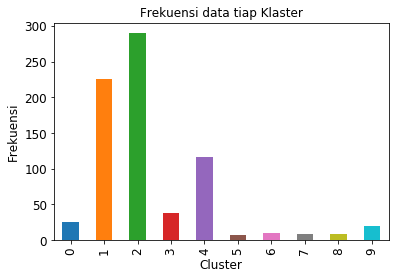

In [103]:
ax = res_.groupby('labels')['labels'].count()
ax = ax.plot(kind='bar', title ="Frekuensi data tiap Klaster", fontsize=12)
ax.set_xlabel("Cluster", fontsize=12)
ax.set_ylabel("Frekuensi", fontsize=12)

In [89]:
res_.groupby('labels')['labels'].count()

labels
0     25
1    226
2    290
3     38
4    117
5      7
6     10
7      9
8      8
9     19
Name: labels, dtype: int64

In [77]:
clf10.inertia_

352.6226541538641

# Drawing Centroid

In [104]:
centers = np.array(clf10.cluster_centers_)

In [106]:
centers.shape

(10, 100)

In [126]:
len(header_tfidf), res_.shape

(12436, (749, 12436))

In [200]:
tempres = res_
tempres.columns =header_tfidf

In [201]:
#karna val object -> jadiin float dulu :(
tempres = tempres.astype(str).astype(float)

## Print significant word each cluster

In [209]:
for row in range(10):
    resrow = tempres[tempres['labels'] == row]
    x = resrow.iloc[:,1:-1]
    #column with max value each row
    aa = x.idxmax(axis=1)
    aa = aa.to_frame()
    aa.columns=["word"]
    hasilrow = aa.groupby('word')['word'].count().sort_values(ascending=False)
    print('\n==================')
    print('cluster:\t', row,'\n')
    print(hasilrow.head(5))


cluster:	 0 

word
said      13
offici     5
ha         3
secur      2
trump      1
Name: word, dtype: int64

cluster:	 1 

word
aa        22
access    11
polic      7
onlin      6
articl     6
Name: word, dtype: int64

cluster:	 2 

word
said      20
parti     15
trump     14
israel    11
debt      10
Name: word, dtype: int64

cluster:	 3 

word
attack       24
istanbul      8
whale         3
said          1
nightclub     1
Name: word, dtype: int64

cluster:	 4 

word
wa           40
polic         8
fernandez     6
said          5
kiniti        4
Name: word, dtype: int64

cluster:	 5 

word
corley    4
stop      3
Name: word, dtype: int64

cluster:	 6 

word
report    10
Name: word, dtype: int64

cluster:	 7 

word
account    9
Name: word, dtype: int64

cluster:	 8 

word
amiridi    8
Name: word, dtype: int64

cluster:	 9 

word
said      6
syria     3
area      3
russia    2
kill      2
Name: word, dtype: int64


## Draw Centroid